In [739]:
#!L
from catboost import CatBoostRegressor, monoforest, Pool, cv
from catboost.utils import create_cd
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, lasso_path
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm as tqdm
from scipy import stats
from sklearn.model_selection import KFold

In [728]:
#!L
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import seaborn as sns
import sys
import warnings

In [702]:
#!L
warnings.filterwarnings('ignore')

In [470]:
#!L
%pip install seaborn

     |████████████████████████████████| 285 kB 2.6 MB/s 
     |████████████████████████████████| 11.6 MB 94 kB/s 
     |████████████████████████████████| 1.1 MB 42.2 MB/s 
     |████████████████████████████████| 14.8 MB 58.7 MB/s 
     |████████████████████████████████| 9.9 MB 57.0 MB/s 
     |████████████████████████████████| 2.2 MB 57.7 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 227 kB 60.6 MB/s 
     |████████████████████████████████| 510 kB 49.7 MB/s 
     |████████████████████████████████| 27.4 MB 53.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.1.0 which is incompatible.
ml-kernel 0.0.1 requires setuptools<=50.3.2, but you have setuptools 51.1.1 which is incompatible.
You should consider upgrading via the '/usr/bin/pyth

In [737]:
#!L
PICKLE_DUMPS_PATH = os.path.join('resources', 'pickle_dumps')

LOGS_PATH = os.path.join('resources', 'logs')

RANDOM_STATE = 23923

def save_via_pickle(obj, filepath):
    with open(filepath, 'wb') as output_file:
        pickle.dump(obj, output_file)
        
def load_from_pickle(filepath):
    with open(filepath, 'rb') as input_file:
        return pickle.load(input_file)
    
def get_pickle_dump_path(dump_name):
    return os.path.join(PICKLE_DUMPS_PATH, f'{dump_name}.pkl')

In [584]:
#!L
def update_log(log_name, lines, clear=False):
    mode = 'w' if clear else 'a'
    with open(os.path.join(LOGS_PATH, f'{log_name}.log'), mode) as log_file:
        log_file.write(os.linesep.join(list(map(str, lines))) + os.linesep)

In [585]:
#!L
catboost_main_argument_grid = {
#     'learning_rate': np.hstack([np.arange(0.001, 0.01, 0.001), 
#                                 np.arange(0.01, 0.1, 0.01), 
#                                 np.arange(0.1, 0.2, 0.01)]),
    'depth': range(1, 9),
#    'iterations': [2500]
}

# catboost_random_argument_grid = {
#     'learning_rate': np.arange(0.2, 1., 0.01),
#     'depth': range(1, 9),
# }

In [399]:
#!L
def train_catboost_reg(X_train, X_val, y_train, y_val, catboost_args, search_by_train_test_split=False):
    reg = CatBoostRegressor(**catboost_args)
    # random_args = reg.randomized_search(catboost_random_argument_grid, X_train, y_train, cv=3, verbose=False, plot=False, n_iter=200)
    # argument_grid = catboost_main_argument_grid.copy()
    # for best_key, best_value in random_args['params'].items():
    #     argument_grid[best_key] = np.hstack([argument_grid[best_key], [best_value]])
    best_args = reg.grid_search(catboost_main_argument_grid, X_train, y_train, cv=3, verbose=False, plot=False, search_by_train_test_split=search_by_train_test_split)
    # reg = CatBoostRegressor(**catboost_args)
    # reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, metric_period=10000)
    print(reg.get_params(), best_args['params'])
    return reg

In [561]:
#!L
def transform_X_catboost(X, monomials):
    X_out = np.ones((X.shape[0], len(monomials)), dtype=np.bool)
    for i, x in enumerate(X):
        for j, monomial in enumerate(monomials):
            for split in monomial.splits:
                X_out[i, j] = X_out[i, j] and np.less_equal(split.border, x[split.feature_idx])
    return X_out

In [599]:
#!L
# def _train_lasso(max_iter, lambda_arg, X, y):
#     return Lasso(max_iter=max_iter, alpha=lambda_arg).fit(X, y)

# def _select_lasso_iter(X_train, X_val, y_train, y_val, lambda_arg, max_iter=2000, iter_step=1):
#     best_score = None
#     best_iter = None
#     for cur_iter in range(1, max_iter + 1, iter_step):
#         lasso = _train_lasso(cur_iter, lambda_arg, X_train, y_train)
#         cur_score = mean_squared_error(y_val, lasso.predict(X_val), squared=False)
#         if best_score is None or cur_score < best_score:
#             best_score = cur_score
#             best_iter = cur_iter
    
#     return best_score, best_iter

def _select_best_lasso_iter(X_train, X_val, y_train, y_val, lambda_arg, max_iter=5000, select_best_iteration=True):
    best_score = None
    best_iter = None
    big_lasso = Lasso(alpha=lambda_arg, max_iter=max_iter).fit(X_train, y_train)
    if not select_best_iteration:
        return mean_squared_error(y_val, big_lasso.predict(X_val), squared=False), max_iter
    lasso = Lasso(alpha=lambda_arg, max_iter=1, warm_start=True)
    for cur_iter in range(1, big_lasso.n_iter_ + 1):
        lasso.fit(X_train, y_train)
        # assert np.allclose(lasso.coef_, Lasso(alpha=lambda_arg, max_iter=cur_iter).fit(X_train, y_train).coef_)
        val_score = mean_squared_error(y_val, lasso.predict(X_val), squared=False)
        if best_score is None or val_score < best_score:
            best_score = val_score
            best_iter = cur_iter
    return best_score, best_iter

def train_best_lasso(X_train, X_val, y_train, y_val, lambda_max=1000, lambda_min=1e-4, decay=0.9,
                     max_iter=5000, iter_step=1, verbose=True, max_lambda_checks=None, without_improvements_filter=None,
                     select_best_iteration=True):
    best_score = None
    best_lambda = None
    best_iter = None
    iter_number = 0
    iter_lim = max_lambda_checks if max_lambda_checks else np.inf
    cur_lambda = lambda_max
    last_imporvment = None
    while np.less(lambda_min, cur_lambda) and iter_number < iter_lim:
        cur_score, cur_iter = _select_best_lasso_iter(X_train, X_val, y_train, y_val, cur_lambda, max_iter, select_best_iteration=select_best_iteration)
        if best_score is None or cur_score < best_score:
            best_score = cur_score
            best_iter = cur_iter
            best_lambda = cur_lambda
            last_imporvment = iter_number
            if verbose:
                print(f'New best score: lambda={cur_lambda}, n_iter={cur_iter}, rmse={cur_score}')
        cur_lambda *= decay
        iter_number += 1
        if verbose and iter_number % 10 == 0:
            print(f'Iter {iter_number}(lambda={cur_lambda}), best: lambda={best_lambda}, n_iter={best_iter}, rmse={best_score}')
        if without_improvements_filter is not None:
            if (last_imporvment is None and iter_number >= without_improvements_filter) or (
                last_imporvment is not None and iter_number - last_imporvment >= without_improvements_filter):
                break
    
    return Lasso(alpha=best_lambda, max_iter = best_iter).fit(X_train, y_train), best_lambda, best_iter

In [402]:
#!L
def get_lasso_and_boosting_difference(X_train, X_val, X_test, y_train, y_val, y_test, catboost_args,
                                      lambda_max=1000, lambda_min=1e-4, decay=0.9, max_iter=5000, iter_step=1):
    reg = train_catboost_reg(X_train, X_val, y_train, y_val, catboost_args)
    catboost_monomials = monoforest.to_polynom(catboost_reg)
    X_train_mon = transform_X_catboost(X_train, catboost_monomials)
    X_val_mon = transform_X_catboost(X_val, catboost_monomials)
    X_test_mon = transform_X_catboost(X_test, catboost_monomials)
    lasso = train_lasso(X_train_mon, X_val_mon, y_train, y_val, 
                        lambda_max=lambda_max, lambda_min=lambda_min, decay=decay, max_iter=max_iter, iter_step=iter_step)
    return mean_squared_error(y_test, reg.predict(X_test), squared=False) - mean_squared_error(y_test, lasso.predict(X_test_mon), squared=False)

In [403]:
#!L
diabetes = load_diabetes()
X, y = diabetes['data'], diabetes['target']

In [257]:
#!L
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [270]:
#!L
rng = np.random.default_rng()

In [271]:
#!L
def generate_train_val_test_split(total_size, val_percent, test_percent, rng):
    ids = rng.permutation(total_size)
    first_border = round(total_size * (1 - val_percent - test_percent))
    second_border = first_border + round(total_size * val_percent)
    return ids[:first_border], ids[first_border:second_border], ids[second_border:]

In [273]:
#!L
splits = [generate_train_val_test_split(X.shape[0], 0.2, 0.2, rng) for _ in range(1000)]

In [279]:
#!L
save_via_pickle(splits, get_pickle_dump_path('diabetes_splits'))

In [697]:
#!L
def build_differences(X, y, catboost_reg_config, splits, dump_titile, splits_to_proceed=None, 
                      val_percent=0.2, test_percent=0.2, select_best_iteration=True, compare_coefs=False):
    header_line = ','.join(['tree count', 'best lambda', 'best iter', 
                            'train reg rmse', 'train lasso rmse', 'val reg rmse',
                            'val lasso rmse', 'test reg rmse', 'test lasso rmse'])
    update_log(dump_titile, [header_line], clear=True)
    if compare_coefs:
        update_log(f'weights_{dump_titile}', ['regressor, lasso'], clear=True)    
    if splits_to_proceed is None:
        splits_to_proceed = len(splits)
    catboost_reg_config.update({ 'verbose' : False, 'iterations' : 5000 })
    reg = CatBoostRegressor(**catboost_reg_config)
    best_depth = reg.grid_search({ 'depth' : range(1, 9) }, X, y, verbose=True, plot=False, cv=5)['params']['depth']
#     best_depth = 1
    print(f'Selected depth: {best_depth}')
    catboost_reg_config.update({ 'depth' : best_depth })
    diffs = []
    log_lines = []
    print(header_line)
    for iter_ind, split in tqdm(enumerate(splits[:splits_to_proceed])):
        reg = CatBoostRegressor(**catboost_reg_config)
        X_train, X_val, X_test, y_train, y_val, y_test = X[split[0]], X[split[1]], X[split[2]], y[split[0]], y[split[1]], y[split[2]]
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        monomials = monoforest.to_polynom(reg)
        X_train_mon = transform_X_catboost(X_train, monomials)
        X_val_mon = transform_X_catboost(X_val, monomials)
        X_test_mon = transform_X_catboost(X_test, monomials)
        lasso, best_lambda, best_iter = train_best_lasso(X_train_mon, X_val_mon, y_train, y_val, verbose=False,
                                                         lambda_max=100, lambda_min=1e-1, decay=0.7,
                                                         without_improvements_filter=20, max_iter=2000, select_best_iteration=select_best_iteration)
        if compare_coefs:
            update_log(f'weights_{dump_titile}', [','.join([str(mon.value[0]) for mon in monomials]), ','.join(list(map(str, lasso.coef_)))], clear=False)
        train_reg_rmse = mean_squared_error(y_train, reg.predict(X_train), squared=False)
        train_lasso_rmse = mean_squared_error(y_train, lasso.predict(X_train_mon), squared=False)
        val_reg_rmse = mean_squared_error(y_val, reg.predict(X_val), squared=False)
        val_lasso_rmse = mean_squared_error(y_val, lasso.predict(X_val_mon), squared=False)
        test_reg_rmse = mean_squared_error(y_test, reg.predict(X_test), squared=False)
        test_lasso_rmse = mean_squared_error(y_test, lasso.predict(X_test_mon), squared=False)
        diffs.append(test_reg_rmse - test_lasso_rmse)
        log_lines.append(','.join(list(map(str, [reg.tree_count_, best_lambda, best_iter, train_reg_rmse, train_lasso_rmse, 
                                                 val_reg_rmse, val_lasso_rmse, test_reg_rmse, test_lasso_rmse]))))
        print(f'{iter_ind},{log_lines[-1]}')
        if iter_ind % 20 == 0:
            save_via_pickle(diffs, get_pickle_dump_path(f'{dump_titile}_{iter_ind}'))
            update_log(dump_titile, log_lines)
            log_lines = []
    save_via_pickle(diffs, get_pickle_dump_path(f'{dump_titile}_{iter_ind}'))
    update_log(dump_titile, log_lines)
    return diffs

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [723]:
#!L
def record_monoforest_len(X, y, catboost_reg_config, splits, dump_titile, splits_to_proceed=None, n_trees=5000):
    update_log(dump_titile, ['total,non-zero'], clear=True)
    if splits_to_proceed is None:
        splits_to_proceed = len(splits)
    catboost_reg_config.update({ 'verbose' : False, 'iterations' : n_trees })
    reg = CatBoostRegressor(**catboost_reg_config)
#     best_depth = reg.grid_search({ 'depth' : range(1, 9) }, X, y, verbose=True, plot=False, cv=5)['params']['depth']
    best_depth = 2
    print(f'Selected depth: {best_depth}')
    catboost_reg_config.update({ 'depth' : best_depth })
    for iter_ind, split in tqdm(enumerate(splits[:splits_to_proceed])):
        reg = CatBoostRegressor(**catboost_reg_config)
        X_train, X_val, X_test, y_train, y_val, y_test = X[split[0]], X[split[1]], X[split[2]], y[split[0]], y[split[1]], y[split[2]]
        reg.fit(X_train, y_train, plot=False, use_best_model=False, verbose=False)
        monomials = monoforest.to_polynom(reg)
        non_zero = 0
        for m in monomials:
            if np.isclose(m.value, 0) or np.isclose(m.weight, 0):
                continue
            non_zero += 1
        update_log(dump_titile, [f'{len(monomials)},{non_zero}'])

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [724]:
#!L
record_monoforest_len(X, y, 
                      { 'boosting_type': 'Plain',
                        'bootstrap_type': 'No',
                        'score_function': 'L2',
                        'leaf_estimation_method': None }, splits, 'default_2_100_monoforest_length', splits_to_proceed=200, n_trees=100)

Selected depth: 2


200it [00:13, 14.66it/s]
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [725]:
#!L
record_monoforest_len(X, y,
                      { 'boosting_type' : 'Plain', 
                        'bootstrap_type' : 'Poisson', 
                        'iterations' : 5000,
                        'task_type' : 'GPU',
                        'score_function' : 'L2', 
                        'leaf_estimation_method': None }, splits, 'bootstrap_monoforest_100_length', splits_to_proceed=200, n_trees=100)

Selected depth: 2


200it [04:08,  1.24s/it]
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [660]:
#!L
def calculate_iverse_leaf_frequencies(reg, X_pool):
    indices = reg.calc_leaf_indexes(X_pool)
    freqs = np.zeros_like(indices, dtype=np.float)
    for tree_number in range(indices.shape[1]):
        unique, counts = np.unique(indices[:, tree_number], return_counts=True)
        freq_map = {unique[i] : counts[i] for i in range(unique.shape[0])}
        freq_funct = np.vectorize(lambda u : 1. / freq_map[u])
        freqs[:, tree_number] = freq_funct(indices[:, tree_number])
    return freqs

In [677]:
#!L
def build_inverse_leaf_frequencies(X, y, catboost_reg_config, splits, dump_name, splits_to_proceed=200):
    catboost_reg_config.update({ 'verbose' : False, 'iterations' : 5000 })
    reg = CatBoostRegressor(**catboost_reg_config)
    # best_depth = reg.grid_search({ 'depth' : range(1, 9) }, X, y, verbose=True, plot=False, cv=5)['params']['depth']
    best_depth = 1
    catboost_reg_config.update({ 'depth' : best_depth })
    X_pool = Pool(data=X, label=y)
    results = np.zeros(shape=(splits_to_proceed, X.shape[0]), dtype=np.float)
    for iter_ind, split in tqdm(enumerate(splits[:splits_to_proceed])):
        reg = CatBoostRegressor(**catboost_reg_config)
        X_train, X_val, X_test, y_train, y_val, y_test = X[split[0]], X[split[1]], X[split[2]], y[split[0]], y[split[1]], y[split[2]]
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        results[iter_ind, :] = np.sum(calculate_iverse_leaf_frequencies(reg, X_pool), axis=1)
        if iter_ind % 10 == 0 or iter_ind == splits_to_proceed - 1:
            save_via_pickle(results, get_pickle_dump_path(dump_name))
    return results

In [678]:
#!L
default_freqs = build_inverse_leaf_frequencies(X, y, { 'boosting_type': 'Plain',
                                                       'bootstrap_type': 'No',
                                                       'score_function': 'L2',
                                                       'leaf_estimation_method': None }, splits, 'default_freqs')

200it [1:28:32, 26.56s/it]


In [679]:
#!L
bootstrap_freqs = build_inverse_leaf_frequencies(X, y, { 'boosting_type' : 'Plain', 
                                                         'bootstrap_type' : 'Poisson', 
                                                         'iterations' : 5000,
                                                         'task_type' : 'GPU',
                                                         'score_function' : 'L2', 
                                                         'leaf_estimation_method': None }, splits, 'bootstrap_freqs')

200it [1:55:31, 34.66s/it]


In [525]:
#!L
diffs = build_differences(X, y, {}, splits, 'fixed_diabetes_empty_argset', splits_to_proceed=200)


bestTest = 46.64237819
bestIteration = 1610

0:	loss: 46.6423782	best: 46.6423782 (0)	total: 842ms	remaining: 5.89s

bestTest = 46.8217287
bestIteration = 643

1:	loss: 46.8217287	best: 46.6423782 (0)	total: 2.67s	remaining: 8.01s

bestTest = 46.91657591
bestIteration = 352

2:	loss: 46.9165759	best: 46.6423782 (0)	total: 4.54s	remaining: 7.58s

bestTest = 46.81004174
bestIteration = 319

3:	loss: 46.8100417	best: 46.6423782 (0)	total: 6.8s	remaining: 6.8s

bestTest = 46.75041907
bestIteration = 251

4:	loss: 46.7504191	best: 46.6423782 (0)	total: 9.71s	remaining: 5.83s

bestTest = 47.51789166
bestIteration = 241

5:	loss: 47.5178917	best: 46.6423782 (0)	total: 15.3s	remaining: 5.11s

bestTest = 49.15100747
bestIteration = 250

6:	loss: 49.1510075	best: 46.6423782 (0)	total: 23.3s	remaining: 3.33s

bestTest = 49.77829496
bestIteration = 322

7:	loss: 49.7782950	best: 46.6423782 (0)	total: 35s	remaining: 0us
Estimating final quality...
Selected depth: 1
tree count,best lambda,best iter

200it [3:22:24, 60.72s/it]


In [ ]:
#!L
save_via_pickle(diffs, get_pickle_dump_path('diabetes_empty_argset_diffs'))

In [328]:
#!L
empty_argset_diffs = load_from_pickle(get_pickle_dump_path('diabetes_empty_argset_diffs_240'))

<AxesSubplot:xlabel='rmse', ylabel='Density'>

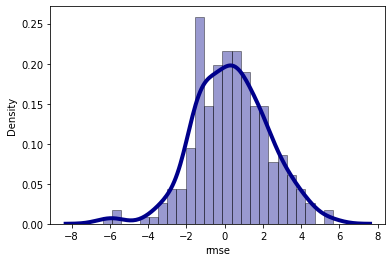

In [329]:
#!L
sns.distplot(empty_argset_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4build
             axlabel='rmse')

In [522]:
#!L
default_argset_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                 'bootstrap_type': 'No',
                                                 'score_function': 'L2',
                                                 'leaf_estimation_method': None }, splits, 'fixed_default_argset_diffs', splits_to_proceed=200)


bestTest = 47.62819728
bestIteration = 1247

0:	loss: 47.6281973	best: 47.6281973 (0)	total: 770ms	remaining: 5.39s

bestTest = 48.43730785
bestIteration = 313

1:	loss: 48.4373078	best: 47.6281973 (0)	total: 1.8s	remaining: 5.41s

bestTest = 48.29833316
bestIteration = 690

2:	loss: 48.2983332	best: 47.6281973 (0)	total: 3.31s	remaining: 5.51s

bestTest = 47.92475698
bestIteration = 524

3:	loss: 47.9247570	best: 47.6281973 (0)	total: 5.27s	remaining: 5.27s

bestTest = 50.29382981
bestIteration = 160

4:	loss: 50.2938298	best: 47.6281973 (0)	total: 7.99s	remaining: 4.79s

bestTest = 51.05994675
bestIteration = 257

5:	loss: 51.0599468	best: 47.6281973 (0)	total: 13.7s	remaining: 4.56s

bestTest = 51.41567931
bestIteration = 185

6:	loss: 51.4156793	best: 47.6281973 (0)	total: 21.3s	remaining: 3.04s

bestTest = 52.57852536
bestIteration = 232

7:	loss: 52.5785254	best: 47.6281973 (0)	total: 31.8s	remaining: 0us
Estimating final quality...
Selected depth: 1
tree count,best lambda,best 

200it [1:28:39, 26.60s/it]


In [695]:
#!L
default_argset_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                 'bootstrap_type': 'No',
                                                 'score_function': 'L2',
                                                 'leaf_estimation_method': None }, splits, 'default_argset_diffs', splits_to_proceed=200, compare_coefs=True)

Selected depth: 1
tree count,best lambda,best iter,train reg rmse,train lasso rmse,val reg rmse,val lasso rmse,test reg rmse,test lasso rmse
0,286,1.9773267429999994,6,50.87506381874422,49.09378245766202,57.93877786091452,58.391775371741005,62.53909458346546,61.81599553054382
1,307,2.8247524899999994,4,48.73232011132694,48.418298794034676,60.22892674745193,60.24281994276216,62.039287516293285,62.282900898217825
2,1491,0.9688901040699995,4,47.105894185687916,48.133373416987865,56.04748393714189,53.78299970794044,54.92596780094499,57.20238996684438
3,1259,0.9688901040699995,2,49.56355616714821,49.80304726338275,53.714618017138235,52.97176278205067,50.0222564409874,49.81936106094834
4,184,11.764899999999999,2,53.62661550011063,60.91026715692031,61.32100852685669,61.798661874024944,61.55071998500402,69.09055900654747
5,2997,2.8247524899999994,2,44.09216268244407,51.999703169667335,55.03072339176381,51.98998400741389,59.9915209265272,64.53234098242277
6,2204,0.6782230728489996,4,46.43549759

200it [13:11,  3.96s/it]


In [336]:
#!L
default_argset_diffs = load_from_pickle(get_pickle_dump_path('default_argset_diffs_240'))

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse', ylabel='Density'>

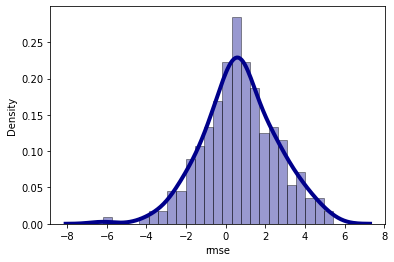

In [338]:
#!L
sns.distplot(default_argset_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse')

In [355]:
#!L
warnings.filterwarnings('ignore')

In [523]:
#!L
bootstrap_argset_diffs = build_differences(X, y, { 'boosting_type' : 'Plain', 
                                                   'bootstrap_type' : 'Poisson', 
                                                   'iterations' : 5000,
                                                   'task_type' : 'GPU',
                                                   'score_function' : 'L2', 
                                                   'leaf_estimation_method': None }, splits, 'fixed_bootstrap_argset_diffs', splits_to_proceed=200)

bestTest = 47.08213038
bestIteration = 1351
0:	loss: 47.0821304	best: 47.0821304 (0)	total: 8.57s	remaining: 1m
bestTest = 46.7243741
bestIteration = 732
1:	loss: 46.7243741	best: 46.7243741 (1)	total: 19.7s	remaining: 59.2s
bestTest = 47.13178542
bestIteration = 362
2:	loss: 47.1317854	best: 46.7243741 (1)	total: 32.4s	remaining: 54s
bestTest = 48.12524259
bestIteration = 299
3:	loss: 48.1252426	best: 46.7243741 (1)	total: 46.3s	remaining: 46.3s
bestTest = 49.27200893
bestIteration = 275
4:	loss: 49.2720089	best: 46.7243741 (1)	total: 1m 1s	remaining: 37s
bestTest = 49.69449504
bestIteration = 292
5:	loss: 49.6944950	best: 46.7243741 (1)	total: 1m 19s	remaining: 26.6s
bestTest = 50.57977415
bestIteration = 198
6:	loss: 50.5797742	best: 46.7243741 (1)	total: 1m 39s	remaining: 14.2s
bestTest = 51.11405133
bestIteration = 290
7:	loss: 51.1140513	best: 46.7243741 (1)	total: 2m 1s	remaining: 0us
Estimating final quality...
Selected depth: 2
tree count,best lambda,best iter,train reg rmse,t

200it [5:52:27, 105.74s/it]


In [703]:
#!L
bootstrap_argset_diffs = build_differences(X, y, { 'boosting_type' : 'Plain', 
                                                   'bootstrap_type' : 'Poisson', 
                                                   'iterations' : 5000,
                                                   'task_type' : 'GPU',
                                                   'score_function' : 'L2', 
                                                   'leaf_estimation_method': None }, splits, 'bootstrap_argset_diffs', splits_to_proceed=200, compare_coefs=True)

bestTest = 47.08213038
bestIteration = 1351
0:	loss: 47.0821304	best: 47.0821304 (0)	total: 9.19s	remaining: 1m 4s
bestTest = 46.7243741
bestIteration = 732
1:	loss: 46.7243741	best: 46.7243741 (1)	total: 20s	remaining: 1m
bestTest = 47.13178542
bestIteration = 362
2:	loss: 47.1317854	best: 46.7243741 (1)	total: 33.5s	remaining: 55.8s
bestTest = 48.12524259
bestIteration = 299
3:	loss: 48.1252426	best: 46.7243741 (1)	total: 47.5s	remaining: 47.5s
bestTest = 49.27200893
bestIteration = 275
4:	loss: 49.2720089	best: 46.7243741 (1)	total: 1m 3s	remaining: 38.2s
bestTest = 49.69449504
bestIteration = 292
5:	loss: 49.6944950	best: 46.7243741 (1)	total: 1m 22s	remaining: 27.5s
bestTest = 50.57977415
bestIteration = 198
6:	loss: 50.5797742	best: 46.7243741 (1)	total: 1m 42s	remaining: 14.6s
bestTest = 51.11405133
bestIteration = 290
7:	loss: 51.1140513	best: 46.7243741 (1)	total: 2m 3s	remaining: 0us
Estimating final quality...
Selected depth: 2
tree count,best lambda,best iter,train reg rmse

200it [3:27:41, 62.31s/it]


In [573]:
#!L
bootstrap_argset_diffs = build_differences(X, y, { 'boosting_type' : 'Plain', 
                                                   'bootstrap_type' : 'Bernoulli', 
                                                   'iterations' : 5000,
                                                   'task_type' : 'GPU',
                                                   'score_function' : 'L2', 
                                                   'leaf_estimation_method': None }, splits[41:], 'upd_fixed_bernoulli_bootstrap_argset_diffs', splits_to_proceed=159)

bestTest = 46.84548884
bestIteration = 1557
0:	loss: 46.8454888	best: 46.8454888 (0)	total: 8.92s	remaining: 1m 2s
bestTest = 46.63796624
bestIteration = 633
1:	loss: 46.6379662	best: 46.6379662 (1)	total: 20.8s	remaining: 1m 2s
bestTest = 47.04972865
bestIteration = 396
2:	loss: 47.0497287	best: 46.6379662 (1)	total: 34.2s	remaining: 57.1s
bestTest = 48.1515121
bestIteration = 230
3:	loss: 48.1515121	best: 46.6379662 (1)	total: 48.2s	remaining: 48.2s
bestTest = 48.56927752
bestIteration = 230
4:	loss: 48.5692775	best: 46.6379662 (1)	total: 1m 5s	remaining: 39.3s
bestTest = 49.86457784
bestIteration = 227
5:	loss: 49.8645778	best: 46.6379662 (1)	total: 1m 24s	remaining: 28.2s
bestTest = 51.51752081
bestIteration = 232
6:	loss: 51.5175208	best: 46.6379662 (1)	total: 1m 44s	remaining: 15s
bestTest = 53.07513026
bestIteration = 231
7:	loss: 53.0751303	best: 46.6379662 (1)	total: 2m 7s	remaining: 0us
Estimating final quality...
Selected depth: 2
tree count,best lambda,best iter,train reg r

159it [4:18:54, 97.70s/it] 


In [618]:
#!L
build_differences(X, y, { 'boosting_type' : 'Plain', 
                          'bootstrap_type' : 'Poisson', 
                          'iterations' : 5000,
                          'task_type' : 'GPU',
                          'score_function' : 'L2', 
                          'leaf_estimation_method': 'Simple' }, splits, 'fixed_bootstrap_argset_simple_leaf_diffs', splits_to_proceed=200)

Selected depth: 1
tree count,best lambda,best iter,train reg rmse,train lasso rmse,val reg rmse,val lasso rmse,test reg rmse,test lasso rmse
Fitted
209


0it [00:31, ?it/s]


In [ ]:
#!L
build_differences(X, y, { 'boosting_type' : 'Plain', 
                          'bootstrap_type' : 'Bernoulli', 
                          'iterations' : 5000,
                          'task_type' : 'GPU',
                          'score_function' : 'L2', 
                          'leaf_estimation_method': 'Simple' }, splits, 'fixed_bernoulli_bootstrap_argset_simple_leaf_diffs', splits_to_proceed=200)

In [551]:
#!L
def build_avg_predictor(splits, y, n_splits=200):
    scores = []
    for split in tqdm(splits[:n_splits]):
        y_test = y[split[2]]
        y_pred = np.array([np.mean(y_test) for _ in range(y_test.shape[0])])
        scores.append(mean_squared_error(y_test, y_pred, squared=False))
    return np.array(scores)

In [554]:
#!L
constant_scores = build_avg_predictor(splits, y)
save_via_pickle(constant_scores, get_pickle_dump_path('constant_scores'))

100%|██████████| 200/200 [00:00<00:00, 786.13it/s]


In [370]:
#!L
bootstrap_argset_diffs = load_from_pickle(get_pickle_dump_path('diabetes_bootstrap_argset_diffs_240'))

<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

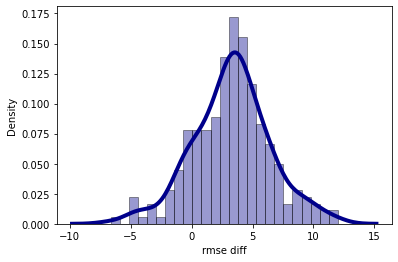

In [372]:
#!L
sns.distplot(bootstrap_argset_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [526]:
#!L
build_differences(X, y, { 'boosting_type': 'Plain',
                          'bootstrap_type': 'No',
                          'score_function': 'NewtonL2',
                          'leaf_estimation_method': None }, splits, 'fixed_LightGBM_argset_diffs', splits_to_proceed=200)


bestTest = 47.62819728
bestIteration = 1247

0:	loss: 47.6281973	best: 47.6281973 (0)	total: 753ms	remaining: 5.27s

bestTest = 48.43730785
bestIteration = 313

1:	loss: 48.4373078	best: 47.6281973 (0)	total: 2.03s	remaining: 6.1s

bestTest = 48.29833316
bestIteration = 690

2:	loss: 48.2983332	best: 47.6281973 (0)	total: 4.38s	remaining: 7.3s

bestTest = 47.92475698
bestIteration = 524

3:	loss: 47.9247570	best: 47.6281973 (0)	total: 6.36s	remaining: 6.36s

bestTest = 50.29382981
bestIteration = 160

4:	loss: 50.2938298	best: 47.6281973 (0)	total: 9.1s	remaining: 5.46s

bestTest = 51.05994675
bestIteration = 257

5:	loss: 51.0599468	best: 47.6281973 (0)	total: 13.9s	remaining: 4.65s

bestTest = 51.41567931
bestIteration = 185

6:	loss: 51.4156793	best: 47.6281973 (0)	total: 21.2s	remaining: 3.03s

bestTest = 52.57852536
bestIteration = 232

7:	loss: 52.5785254	best: 47.6281973 (0)	total: 31.9s	remaining: 0us
Estimating final quality...
Selected depth: 1
tree count,best lambda,best it

15it [06:52, 27.50s/it]


KeyboardInterrupt: 

<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

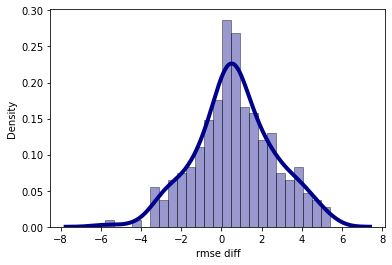

In [376]:
#!L
sns.distplot(load_from_pickle(get_pickle_dump_path('diabetes_LightGBM_argset_diffs_240')), hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [380]:
#!L
diffs1 = load_from_pickle(get_pickle_dump_path('diabetes_bootstrap_argset_diffs_240'))
diffs2 = load_from_pickle(get_pickle_dump_path('diabetes_LightGBM_argset_diffs_240'))
diffs3 = load_from_pickle(get_pickle_dump_path('diabetes_empty_argset_diffs_240'))
diffs4 = load_from_pickle(get_pickle_dump_path('diabetes_default_argset_diffs_240'))

In [387]:
#!L
from scipy.stats import pearsonr
for i, diff1 in enumerate([diffs1, diffs2, diffs3, diffs4]):
    for j, diff2 in enumerate([diffs1, diffs2, diffs3, diffs4]):
        print(f'{i} - {j}: {pearsonr(diff1, diff2)[0]}')

0 - 0: 1.0
0 - 1: 0.23470221625047263
0 - 2: 0.15576467121392362
0 - 3: 0.24665794333884475
1 - 0: 0.23470221625047263
1 - 1: 1.0
1 - 2: 0.5367101088393159
1 - 3: 0.9356942731898966
2 - 0: 0.15576467121392362
2 - 1: 0.5367101088393159
2 - 2: 1.0
2 - 3: 0.5385846287937043
3 - 0: 0.24665794333884475
3 - 1: 0.9356942731898966
3 - 2: 0.5385846287937043
3 - 3: 1.0


In [411]:
#!L
# default_argset_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
#                                                  'bootstrap_type': 'No',
#                                                  'score_function': 'L2',
#                                                  'grow_policy': 'Depthwise',
#                                                  'leaf_estimation_method': None }, splits, 'depthwise_trees_argset_diffs')

0it [00:00, ?it/s]

Selected depth: 1


[0;31mKernelNotResponding[0m: Kernel died unexpectedly and has been restarted. If it's not coming back, please, try restarting from the main menu.

In [413]:
#!L
# reg = CatBoostRegressor(**{ 'boosting_type': 'Plain',
#                             'bootstrap_type': 'No',
#                             'score_function': 'L2',
#                             'grow_policy': 'Depthwise',
#                             'leaf_estimation_method': None,
#                             'depth' : 1})

In [588]:
#!L
border_count_32_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 32,
                                                  'leaf_estimation_method': None }, splits, 'fixed_diabetes_border_count_32_argset_diffs', splits_to_proceed=200)


bestTest = 47.84973741
bestIteration = 1912

0:	loss: 47.8497374	best: 47.8497374 (0)	total: 819ms	remaining: 5.73s

bestTest = 49.0560441
bestIteration = 431

1:	loss: 49.0560441	best: 47.8497374 (0)	total: 1.67s	remaining: 5.01s

bestTest = 47.98093788
bestIteration = 176

2:	loss: 47.9809379	best: 47.8497374 (0)	total: 4.3s	remaining: 7.17s

bestTest = 48.34630192
bestIteration = 187

3:	loss: 48.3463019	best: 47.8497374 (0)	total: 5.81s	remaining: 5.81s

bestTest = 49.11320048
bestIteration = 163

4:	loss: 49.1132005	best: 47.8497374 (0)	total: 8.08s	remaining: 4.85s

bestTest = 49.74847065
bestIteration = 185

5:	loss: 49.7484706	best: 47.8497374 (0)	total: 11.8s	remaining: 3.92s

bestTest = 50.66070641
bestIteration = 216

6:	loss: 50.6607064	best: 47.8497374 (0)	total: 14.7s	remaining: 2.09s

bestTest = 50.13245516
bestIteration = 181

7:	loss: 50.1324552	best: 47.8497374 (0)	total: 19.1s	remaining: 0us
Estimating final quality...
Selected depth: 1
tree count,best lambda,best i

200it [1:20:01, 24.01s/it]


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

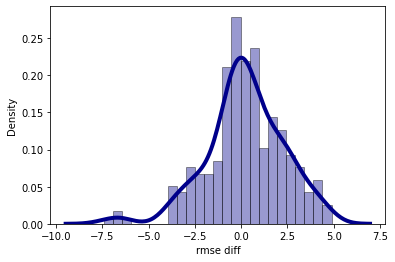

In [422]:
#!L
sns.distplot(load_from_pickle(get_pickle_dump_path('diabetes_border_count_32_argset_diffs_240')), hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [589]:
#!L
border_count_64_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 64,
                                                  'leaf_estimation_method': None }, splits, 'fixed_diabetes_border_count_64_argset_diffs', splits_to_proceed=200)


bestTest = 48.19351135
bestIteration = 1446

0:	loss: 48.1935114	best: 48.1935114 (0)	total: 891ms	remaining: 6.24s

bestTest = 49.3652938
bestIteration = 330

1:	loss: 49.3652938	best: 48.1935114 (0)	total: 1.89s	remaining: 5.67s

bestTest = 48.63684714
bestIteration = 219

2:	loss: 48.6368471	best: 48.1935114 (0)	total: 3.53s	remaining: 5.89s

bestTest = 48.81156141
bestIteration = 187

3:	loss: 48.8115614	best: 48.1935114 (0)	total: 5.66s	remaining: 5.66s

bestTest = 49.75792164
bestIteration = 183

4:	loss: 49.7579216	best: 48.1935114 (0)	total: 7.89s	remaining: 4.74s

bestTest = 50.79983978
bestIteration = 167

5:	loss: 50.7998398	best: 48.1935114 (0)	total: 10.9s	remaining: 3.64s

bestTest = 51.24108163
bestIteration = 172

6:	loss: 51.2410816	best: 48.1935114 (0)	total: 15.5s	remaining: 2.22s

bestTest = 51.22165365
bestIteration = 194

7:	loss: 51.2216537	best: 48.1935114 (0)	total: 21.2s	remaining: 0us
Estimating final quality...
Selected depth: 1
tree count,best lambda,best 

200it [1:21:37, 24.49s/it]


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

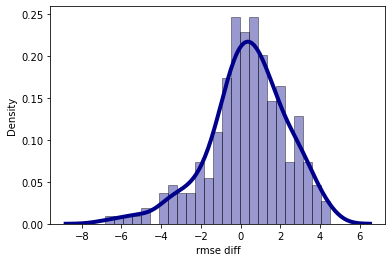

In [429]:
#!L
sns.distplot(load_from_pickle(get_pickle_dump_path('diabetes_border_count_64_argset_diffs_240')), hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [590]:
#!L
border_count_96_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 96,
                                                  'leaf_estimation_method': None }, splits, 'fixed_diabetes_border_count_96_argset_diffs', splits_to_proceed=200)


bestTest = 48.08740901
bestIteration = 1107

0:	loss: 48.0874090	best: 48.0874090 (0)	total: 967ms	remaining: 6.77s

bestTest = 48.66361094
bestIteration = 320

1:	loss: 48.6636109	best: 48.0874090 (0)	total: 2.58s	remaining: 7.73s

bestTest = 49.00815677
bestIteration = 180

2:	loss: 49.0081568	best: 48.0874090 (0)	total: 4.03s	remaining: 6.71s

bestTest = 48.64713643
bestIteration = 552

3:	loss: 48.6471364	best: 48.0874090 (0)	total: 5.62s	remaining: 5.62s

bestTest = 50.45229932
bestIteration = 171

4:	loss: 50.4522993	best: 48.0874090 (0)	total: 7.71s	remaining: 4.62s

bestTest = 50.95457399
bestIteration = 167

5:	loss: 50.9545740	best: 48.0874090 (0)	total: 11.4s	remaining: 3.8s

bestTest = 51.22058483
bestIteration = 224

6:	loss: 51.2205848	best: 48.0874090 (0)	total: 16.2s	remaining: 2.32s

bestTest = 52.0577054
bestIteration = 198

7:	loss: 52.0577054	best: 48.0874090 (0)	total: 23.4s	remaining: 0us
Estimating final quality...
Selected depth: 1
tree count,best lambda,best i

200it [1:23:28, 25.04s/it]


/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

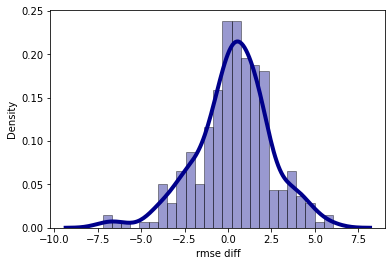

In [442]:
#!L
sns.distplot(border_count_96_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [435]:
#!L
border_count_128_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 128,
                                                  'leaf_estimation_method': None }, splits, 'diabetes_border_count_128_argset_diffs', 260)


bestTest = 47.59655838
bestIteration = 1302

0:	loss: 47.5965584	best: 47.5965584 (0)	total: 757ms	remaining: 5.3s

bestTest = 48.5784928
bestIteration = 296

1:	loss: 48.5784928	best: 47.5965584 (0)	total: 1.72s	remaining: 5.17s

bestTest = 48.97484891
bestIteration = 533

2:	loss: 48.9748489	best: 47.5965584 (0)	total: 3.06s	remaining: 5.1s

bestTest = 48.03993998
bestIteration = 378

3:	loss: 48.0399400	best: 47.5965584 (0)	total: 4.83s	remaining: 4.83s

bestTest = 50.55894571
bestIteration = 187

4:	loss: 50.5589457	best: 47.5965584 (0)	total: 7.27s	remaining: 4.36s

bestTest = 51.30399394
bestIteration = 189

5:	loss: 51.3039939	best: 47.5965584 (0)	total: 11.8s	remaining: 3.92s

bestTest = 52.44378359
bestIteration = 181

6:	loss: 52.4437836	best: 47.5965584 (0)	total: 18.7s	remaining: 2.67s

bestTest = 52.78356741
bestIteration = 200

7:	loss: 52.7835674	best: 47.5965584 (0)	total: 27.2s	remaining: 0us
Estimating final quality...
Selected depth: 1
New best score: lambda=100, n_

260it [36:52,  8.51s/it]


/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

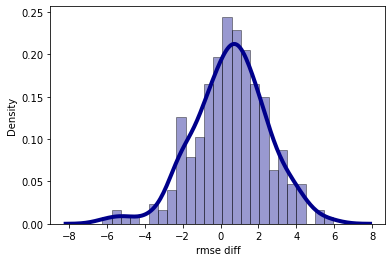

In [443]:
#!L
sns.distplot(border_count_128_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [ ]:
#!L
border_count_160_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 160,
                                                  'leaf_estimation_method': None }, splits, 'fixed_diabetes_border_count_160_argset_diffs', splits_to_proceed=200)

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

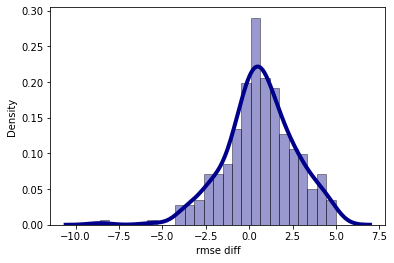

In [444]:
#!L
sns.distplot(border_count_160_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [437]:
#!L
border_count_192_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 192,
                                                  'leaf_estimation_method': None }, splits, 'fixed_diabetes_border_count_192_argset_diffs', splits_to_proceed=200)


bestTest = 47.52244495
bestIteration = 1607

0:	loss: 47.5224449	best: 47.5224449 (0)	total: 742ms	remaining: 5.2s

bestTest = 48.37139483
bestIteration = 307

1:	loss: 48.3713948	best: 47.5224449 (0)	total: 1.87s	remaining: 5.6s

bestTest = 48.50344387
bestIteration = 707

2:	loss: 48.5034439	best: 47.5224449 (0)	total: 3.38s	remaining: 5.63s

bestTest = 48.13862055
bestIteration = 431

3:	loss: 48.1386206	best: 47.5224449 (0)	total: 5.35s	remaining: 5.35s

bestTest = 49.92102141
bestIteration = 170

4:	loss: 49.9210214	best: 47.5224449 (0)	total: 8.4s	remaining: 5.04s

bestTest = 50.80000085
bestIteration = 181

5:	loss: 50.8000008	best: 47.5224449 (0)	total: 12.4s	remaining: 4.13s

bestTest = 51.79159266
bestIteration = 166

6:	loss: 51.7915927	best: 47.5224449 (0)	total: 19.2s	remaining: 2.74s

bestTest = 51.99573854
bestIteration = 228

7:	loss: 51.9957385	best: 47.5224449 (0)	total: 29.4s	remaining: 0us
Estimating final quality...
Selected depth: 1
New best score: lambda=100, n_

260it [37:03,  8.55s/it]


/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

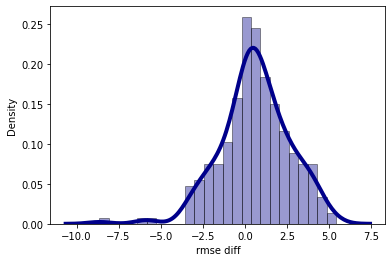

In [445]:
#!L
sns.distplot(border_count_192_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [ ]:
#!L
border_count_224_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 224,
                                                  'leaf_estimation_method': None }, splits, 'fixed_diabetes_border_count_224_argset_diffs', splits_to_proceed=200)

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

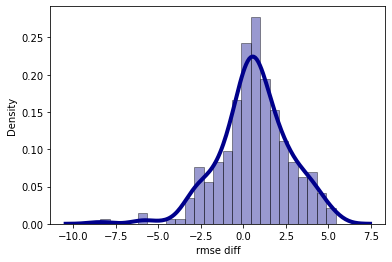

In [446]:
#!L
sns.distplot(border_count_224_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [ ]:
#!L
border_count_255_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                  'bootstrap_type': 'No',
                                                  'score_function': 'L2',
                                                  'border_count': 255,
                                                  'leaf_estimation_method': None }, splits, 'fixed_diabetes_border_count_255_argset_diffs', splits_to_proceed=200)

/home/jupyter/work/pyenv/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

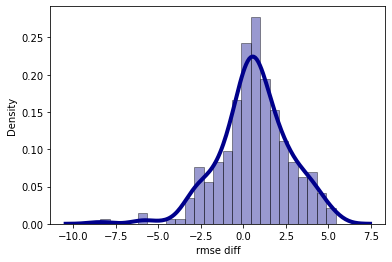

In [447]:
#!L
sns.distplot(border_count_255_diffs, hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [458]:
#!L
warnings.filterwarnings('ignore')

In [463]:
#!L
default_without_best_iteration_diffs = build_differences(X, y, { 'boosting_type': 'Plain',
                                                                 'bootstrap_type': 'No',
                                                                 'score_function': 'L2',
                                                                 'leaf_estimation_method': None }, splits, 'default_without_best_iteration_diffs', 260, select_best_iteration=False)

Selected depth: 1
New best score: lambda=100, n_iter=2000, rmse=73.55835347465174
New best score: lambda=12.959999999999999, n_iter=2000, rmse=64.39847098257444
New best score: lambda=7.775999999999999, n_iter=2000, rmse=59.77149531996321
New best score: lambda=4.6655999999999995, n_iter=2000, rmse=58.80827273201162
Iter: 0, diff: -0.11043645030620297
New best score: lambda=100, n_iter=2000, rmse=76.31655346363198
New best score: lambda=21.599999999999998, n_iter=2000, rmse=75.9401051399955
New best score: lambda=12.959999999999999, n_iter=2000, rmse=66.54027859046556
New best score: lambda=7.775999999999999, n_iter=2000, rmse=63.12060824384524
New best score: lambda=4.6655999999999995, n_iter=2000, rmse=61.08029158008063
New best score: lambda=2.7993599999999996, n_iter=2000, rmse=60.52724415909046
New best score: lambda=1.6796159999999998, n_iter=2000, rmse=60.29752495725535
New best score: lambda=100, n_iter=2000, rmse=79.85647854092237
New best score: lambda=12.959999999999999, n_i

260it [27:37,  6.38s/it]


<AxesSubplot:xlabel='rmse diff', ylabel='Density'>

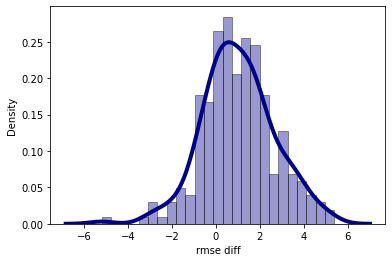

In [464]:
#!L
sns.distplot(load_from_pickle(get_pickle_dump_path('default_without_best_iteration_diffs_240')), hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             axlabel='rmse diff')

In [758]:
#!L
def chose_learning_rate(regressor_params, X, y, target_number_of_trees=10000, delta_tolerance=0.1, number_of_batches=5, decay=0.75, verbose=False):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1./number_of_batches, random_state=RANDOM_STATE, shuffle=True)
    reg = CatBoostRegressor(**regressor_params)
    reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
    lr = reg.learning_rate_
    regressor_params['iterations'] = target_number_of_trees
    while True:
        regressor_params['learning_rate'] = lr
        number_of_trees = []
        kf = KFold(n_splits=number_of_batches, shuffle=True, random_state=RANDOM_STATE)
        for train_index, test_index in kf.split(X):
            reg = CatBoostRegressor(**regressor_params)
            reg.fit(X[train_index], y[train_index], eval_set=(X[test_index], y[test_index]), plot=False, use_best_model=True, verbose=False)
            number_of_trees.append(reg.tree_count_)
        all_close_to_target = True
        for number in number_of_trees:
            all_close_to_target = all_close_to_target and np.less(1. * np.abs(number - target_number_of_trees) / target_number_of_trees, delta_tolerance)
        if verbose:
            trees = ', '.join(list(map(str, number_of_trees)))
            print(f'LR: {lr}, #trees: {trees}')
        if all_close_to_target:
            break
        lr *= decay
    return lr

In [731]:
#!L
X.shape

(442, 10)

In [743]:
#!L
default_params = { 'boosting_type': 'Plain',
                   'bootstrap_type': 'No',
                   'score_function': 'L2',
                   'leaf_estimation_method': None }

In [774]:
#!L
bootstrap_params = { 'boosting_type' : 'Plain', 
                     'bootstrap_type' : 'Poisson', 
                     'iterations' : 5000,
                     'task_type' : 'GPU',
                     'score_function' : 'L2', 
                     'leaf_estimation_method': None }

In [873]:
#!L
all_params = {
    'default' : default_params,
    'bootstrap' : bootstrap_params
}

In [759]:
#!L
params = default_params.copy()
params['depth'] = 2
print(params)
chose_learning_rate(params, X, y, target_number_of_trees=5000, verbose=True)

{'boosting_type': 'Plain', 'bootstrap_type': 'No', 'score_function': 'L2', 'leaf_estimation_method': None, 'depth': 2}
LR: 0.037845999002456665, #trees: 276, 223, 591, 194, 632
LR: 0.0283844992518425, #trees: 358, 362, 750, 286, 805
LR: 0.021288374438881874, #trees: 527, 423, 729, 376, 1072
LR: 0.015966280829161406, #trees: 655, 621, 1346, 491, 1378
LR: 0.011974710621871054, #trees: 911, 846, 1683, 679, 1877
LR: 0.00898103296640329, #trees: 1188, 1116, 2753, 855, 2517
LR: 0.006735774724802468, #trees: 1574, 1553, 2612, 1201, 3294
LR: 0.005051831043601851, #trees: 2145, 1986, 4948, 1592, 4462
LR: 0.0037888732827013882, #trees: 2835, 2659, 4757, 2101, 4993
LR: 0.002841654962026041, #trees: 3825, 3486, 2448, 2809, 4447
LR: 0.002131241221519531, #trees: 5000, 4676, 3289, 3757, 4987
LR: 0.0015984309161396482, #trees: 5000, 4988, 4367, 4971, 5000
LR: 0.0011988231871047361, #trees: 4997, 4978, 4981, 4272, 4985
LR: 0.0008991173903285521, #trees: 2972, 4992, 4994, 4908, 4984
LR: 0.0006743380427

0.0005057535320598106

In [769]:
#!L
def log_monomials_number(params, X, y, splits, log_name, target_number_of_trees=5000, depth=2, splits_to_proceed=200):
    update_log(log_name, ['#depth,#trees,#monomials,#non-zero monmials'], clear=True)
    params['depth'] = depth
    params['iterations'] = target_number_of_trees
    lr = chose_learning_rate(params.copy(), X, y, target_number_of_trees=target_number_of_trees, verbose=True)
    params['learning_rate'] = lr
    for iter_ind, split in tqdm(enumerate(splits[:splits_to_proceed])):
        X_train, X_val, y_train, y_val = np.vstack([X[split[0]], X[split[1]]]), X[split[2]], np.concatenate([y[split[0]], y[split[1]]]), y[split[2]]
        reg = CatBoostRegressor(**params)
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        monomials = monoforest.to_polynom(reg)
        non_zero = 0
        for m in monomials:
            if np.isclose(m.value, 0) or np.isclose(m.weight, 0):
                continue
            non_zero += 1
        update_log(log_name, [f'{depth},{reg.tree_count_},{len(monomials)},{non_zero}'])

In [771]:
#!L
log_monomials_number(default_params.copy(), X, y, splits, 'diabetes_monomials_number_defalt_2')

LR: 0.01388499978929758, #trees: 780, 732, 1466, 563, 1611
LR: 0.010413749841973186, #trees: 1053, 895, 2427, 748, 2116
LR: 0.007810312381479889, #trees: 1364, 1283, 900, 1026, 2837
LR: 0.005857734286109917, #trees: 1860, 1661, 3632, 1324, 3843
LR: 0.004393300714582438, #trees: 2449, 2272, 4737, 1782, 4965
LR: 0.0032949755359368282, #trees: 3273, 3058, 2139, 2391, 3887
LR: 0.002471231651952621, #trees: 4294, 4112, 2845, 3252, 4999
LR: 0.0018534237389644659, #trees: 4996, 4980, 3782, 4266, 4998
LR: 0.0013900678042233494, #trees: 4997, 4988, 5000, 5000, 4995


200it [04:55,  1.48s/it]


In [772]:
#!L
log_monomials_number(default_params.copy(), X, y, splits, 'diabetes_monomials_number_defalt_3', depth=3)

LR: 0.01388499978929758, #trees: 394, 366, 381, 433, 909
LR: 0.010413749841973186, #trees: 520, 569, 377, 463, 1198
LR: 0.007810312381479889, #trees: 570, 649, 1002, 550, 1622
LR: 0.005857734286109917, #trees: 778, 918, 844, 871, 2169
LR: 0.004393300714582438, #trees: 1021, 1124, 1128, 1287, 2848
LR: 0.0032949755359368282, #trees: 1364, 1524, 2442, 1720, 3748
LR: 0.002471231651952621, #trees: 1830, 1885, 3230, 2050, 4973
LR: 0.0018534237389644659, #trees: 2433, 2538, 2708, 2931, 4165
LR: 0.0013900678042233494, #trees: 3219, 3335, 3585, 3647, 4991
LR: 0.001042550853167512, #trees: 4305, 4469, 4747, 4807, 4997
LR: 0.000781913139875634, #trees: 4994, 5000, 4943, 4910, 5000


200it [06:41,  2.01s/it]


In [770]:
#!L
log_monomials_number(default_params.copy(), X, y, splits, 'diabetes_monomials_number_defalt_4', depth=4)

LR: 0.01388499978929758, #trees: 192, 328, 262, 253, 929
LR: 0.010413749841973186, #trees: 226, 438, 352, 320, 1201
LR: 0.007810312381479889, #trees: 307, 581, 412, 449, 1680
LR: 0.005857734286109917, #trees: 437, 777, 529, 603, 2043
LR: 0.004393300714582438, #trees: 574, 1028, 731, 783, 3522
LR: 0.0032949755359368282, #trees: 735, 1380, 1015, 1052, 3666
LR: 0.002471231651952621, #trees: 1057, 1827, 1311, 1414, 4418
LR: 0.0018534237389644659, #trees: 1362, 2410, 1811, 1909, 4998
LR: 0.0013900678042233494, #trees: 1829, 3237, 2296, 2478, 4997
LR: 0.001042550853167512, #trees: 2495, 4314, 3133, 3341, 5000
LR: 0.000781913139875634, #trees: 3452, 4999, 4224, 4495, 5000
LR: 0.0005864348549067255, #trees: 4614, 5000, 5000, 4997, 5000


200it [08:53,  2.67s/it]


In [775]:
#!L
log_monomials_number(bootstrap_params.copy(), X, y, splits, 'diabetes_monomials_number_bootstrap_2')

LR: 0.03256699815392494, #trees: 339, 445, 645, 300, 411
LR: 0.024425248615443707, #trees: 337, 682, 648, 396, 411
LR: 0.01831893646158278, #trees: 264, 546, 1176, 507, 784
LR: 0.013739202346187085, #trees: 331, 1263, 1682, 899, 892
LR: 0.010304401759640314, #trees: 425, 1065, 1682, 1062, 1305
LR: 0.007728301319730235, #trees: 594, 1783, 2734, 1608, 1868
LR: 0.0057962259897976764, #trees: 928, 1783, 4054, 1615, 1892
LR: 0.004347169492348257, #trees: 941, 2228, 5000, 3161, 3666
LR: 0.003260377119261193, #trees: 1325, 2353, 5000, 3442, 3843
LR: 0.0024452828394458948, #trees: 2194, 2997, 5000, 4446, 4936
LR: 0.001833962129584421, #trees: 2414, 4709, 5000, 4770, 4899
LR: 0.0013754715971883158, #trees: 3017, 4960, 5000, 5000, 4978
LR: 0.0010316036978912368, #trees: 4205, 4994, 5000, 5000, 4997
LR: 0.0007737027734184276, #trees: 4802, 4994, 5000, 5000, 5000


200it [33:43, 10.12s/it]


In [776]:
#!L
log_monomials_number(bootstrap_params.copy(), X, y, splits, 'diabetes_monomials_number_bootstrap_3', depth=3)

LR: 0.03256699815392494, #trees: 98, 638, 298, 220, 247
LR: 0.024425248615443707, #trees: 112, 670, 375, 283, 380
LR: 0.01831893646158278, #trees: 251, 431, 552, 341, 615
LR: 0.013739202346187085, #trees: 265, 691, 1005, 508, 785
LR: 0.010304401759640314, #trees: 292, 1251, 996, 847, 790
LR: 0.007728301319730235, #trees: 468, 2248, 978, 902, 1665
LR: 0.0057962259897976764, #trees: 664, 1065, 1691, 1520, 1891
LR: 0.004347169492348257, #trees: 909, 2228, 2291, 1615, 2976
LR: 0.003260377119261193, #trees: 1150, 2228, 2740, 2506, 3632
LR: 0.0024452828394458948, #trees: 1356, 2403, 4414, 3458, 4707
LR: 0.001833962129584421, #trees: 1974, 3168, 4483, 4161, 4725
LR: 0.0013754715971883158, #trees: 2414, 4106, 5000, 4770, 4936
LR: 0.0010316036978912368, #trees: 3838, 4960, 5000, 5000, 5000
LR: 0.0007737027734184276, #trees: 4852, 4988, 5000, 5000, 4998


200it [41:45, 12.53s/it]


In [777]:
#!L
log_monomials_number(bootstrap_params.copy(), X, y, splits, 'diabetes_monomials_number_bootstrap_4', depth=4)

LR: 0.03256699815392494, #trees: 110, 508, 300, 166, 233
LR: 0.024425248615443707, #trees: 114, 126, 209, 283, 268
LR: 0.01831893646158278, #trees: 132, 690, 352, 328, 356
LR: 0.013739202346187085, #trees: 250, 453, 438, 504, 682
LR: 0.010304401759640314, #trees: 292, 456, 645, 669, 719
LR: 0.007728301319730235, #trees: 453, 692, 982, 951, 1154
LR: 0.0057962259897976764, #trees: 501, 692, 982, 1104, 1535
LR: 0.004347169492348257, #trees: 677, 1005, 1729, 1656, 1910
LR: 0.003260377119261193, #trees: 1139, 1541, 1802, 1935, 2346
LR: 0.0024452828394458948, #trees: 1257, 2259, 2239, 2904, 4188
LR: 0.001833962129584421, #trees: 1563, 2806, 3068, 3442, 4375
LR: 0.0013754715971883158, #trees: 2434, 3177, 4728, 4164, 4898
LR: 0.0010316036978912368, #trees: 2837, 4800, 5000, 4931, 4991
LR: 0.0007737027734184276, #trees: 4197, 4988, 4998, 5000, 5000
LR: 0.0005802770800638207, #trees: 4991, 4988, 5000, 5000, 5000


200it [54:35, 16.38s/it]


In [837]:
#!L
def chose_stable_learning_rate(regressor_params, X, y, max_delta_tolerance=0.25, number_of_batches=5, decay=0.9, verbose=False, initial_lr=None, max_iter=50):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1./number_of_batches, random_state=RANDOM_STATE, shuffle=True)
    if initial_lr is None:
        reg = CatBoostRegressor(**regressor_params)
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        lr = reg.learning_rate_
    else:
        lr = initial_lr
    best_rmse = None
    best_lr = None
    for _ in range(max_iter):
        regressor_params['learning_rate'] = lr
        rmses = []
        kf = KFold(n_splits=number_of_batches, shuffle=True, random_state=RANDOM_STATE)
        for train_index, test_index in kf.split(X):
            X_train, X_val, y_train, y_val = train_test_split(X[train_index], y[train_index], random_state=RANDOM_STATE, test_size=0.25)
            reg = CatBoostRegressor(**regressor_params)
            reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
            rmses.append(mean_squared_error(y[test_index], reg.predict(X[test_index])))
        all_close_to_target = True
        target = np.mean(rmses)
        errors = []
        for rmse in rmses:
            errors.append(1. * np.abs(rmse - target) / target)
            all_close_to_target = all_close_to_target and np.less(errors[-1], max_delta_tolerance)
        if verbose:
            rmses_str = ', '.join(list(map(str, zip(rmses, errors))))
            print(f'LR: {lr}, rmses: {rmses_str}')
            print(f'Mean rmse: {np.mean(rmses)}')
        if all_close_to_target:
            if best_rmse is None or target < best_rmse:
                best_rmse = target
                best_lr = lr
                if verbose:
                    print(f'Found new best lr: {best_lr}')
        lr *= decay
    return best_lr

In [804]:
#!L
params = default_params.copy()
params['depth'] = 2
print(params)
chose_stable_learning_rate(params, X, y, verbose=True, initial_lr=0.1)

{'boosting_type': 'Plain', 'bootstrap_type': 'No', 'score_function': 'L2', 'leaf_estimation_method': None, 'depth': 2}
LR: 0.1, rmses: (2644.5933997114407, 0.18926820976613457), (3216.684014242325, 0.013886977949847133), (3404.8077690011614, 0.04378461288819623), (3286.8484118842357, 0.007622758751875737), (3756.981913399239, 0.15174781607591015)
Mean rmse: 3261.98310164768
Found new best lr: 0.1
LR: 0.09000000000000001, rmses: (2645.61740184994, 0.18498112177206888), (3183.7650899164382, 0.01919731465686704), (3376.4988225189863, 0.04017696615659145), (3264.0455528676057, 0.005534187642871272), (3760.478786776293, 0.15846728262947266)
Mean rmse: 3246.081130785853
Found new best lr: 0.09000000000000001
LR: 0.08100000000000002, rmses: (2650.0799324797285, 0.1838394466991938), (3183.109939257692, 0.019679090656362277), (3394.2679075077904, 0.04535245880320957), (3270.6720032532876, 0.007287908234095715), (3736.910748203362, 0.15087817031825151)
Mean rmse: 3247.0081061403716
LR: 0.0729000

0.06561000000000002

In [852]:
#!L
def chose_median_stable_learning_rate(regressor_params, X, y, repeat_iterations=10, number_of_batches=5, lr_initial=0.4, lr_decay=0.8, lr_iterations=30, verbose=False):
    best_lrs = []
    for repeat_iter in range(repeat_iterations):
        print(f'Iteration: {repeat_iter}')
        lr = lr_initial
        best_rmse = None
        best_lr = None
        kf = KFold(n_splits=number_of_batches, shuffle=True)
        batches = [(train_index, test_index) for train_index, test_index in kf.split(X)]
        for _ in tqdm(range(lr_iterations)):
            regressor_params['learning_rate'] = lr
            rmses = []
            for batch_train, batch_test in batches:
                X_train, X_val, y_train, y_val = train_test_split(X[batch_train], y[batch_train], random_state=RANDOM_STATE, test_size=1./(number_of_batches - 1))
                reg = CatBoostRegressor(**regressor_params)
                reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
                rmses.append(mean_squared_error(y[batch_test], reg.predict(X[batch_test])))
            achieved_rmse = np.mean(rmses)
            if best_rmse is None or best_rmse > achieved_rmse:
                if verbose:
                    print(f'Found new best lr: {lr}, mean rmse: {achieved_rmse}')
                best_rmse = achieved_rmse
                best_lr = lr
            lr *= lr_decay
        best_lrs.append(best_lr)
    return np.median(best_lrs)

In [827]:
#!L
params = default_params.copy()
params['depth'] = 2
chose_median_stable_learning_rate(params, X, y, verbose=True)

Iteration: 0
12
8
29
11
8
Found new best lr: 0.5, mean rmse: 3330.6646915810006
6
40
11
9
8
Found new best lr: 0.45, mean rmse: 3278.2062375044247
9
23
10
13
17
Found new best lr: 0.405, mean rmse: 3255.698733277528
16
12
9
15
18
21
23
17
12
21
Found new best lr: 0.32805000000000006, mean rmse: 3206.4740474486366
13
25
21
14
37
34
41
35
18
26
15
35
27
23
24
44
45
27
21
47
21
53
36
38
25
26
43
33
20
34
29
39
37
42
46
27
45
36
30
66
31
73
83
44
44
80
63
54
64
74
69
76
52
59
27
44
69
67
76
95
101
126
77
80
80
55
127
71
86
95
58
158
85
109
137
67
156
106
95
118
73
189
99
131
49
79
159
116
133
53
96
224
125
164
58
111
278
147
141
64
113
309
155
180
74
130
356
198
215
97
130
265
204
125
99
160
276
219
138
130
171
455
288
152
134
185
498
266
170
149
216
592
305
190
162
239
586
379
209
199
258
744
375
231
220
297
583
409
255
233
328
608
466
285
248
357
689
531
317
281
404
976
549
358
332
456
824


 51%|█████     | 38/75 [00:14<00:14,  2.61it/s]


KeyboardInterrupt: 

In [843]:
#!L
import warnings
warnings.filterwarnings('ignore')

In [867]:
#!L
def get_leaves_distribution_variance(reg, X, y, X_train, y_train):
    X_pool = Pool(data=X, label=y)
    X_train_pool = Pool(data=X_train, label=y_train)
    indices = reg.calc_leaf_indexes(X_pool)
    indices_train = reg.calc_leaf_indexes(X_train_pool)
    counts = []
    counts_train = []
    leaves_count = 0
    for tree_number in range(indices.shape[1]):
        _, tree_counts = np.unique(indices[:, tree_number], return_counts=True)
        _, tree_counts_train = np.unique(indices_train[:, tree_number], return_counts=True)
        leaves_count += tree_counts.shape[0]
        counts.extend(tree_counts)
        counts_train.extend(tree_counts_train)
    return np.var(np.log(counts) + 1), np.var(np.log(counts_train) + 1), leaves_count

In [869]:
#!L
def build_differences_for_depth(depth, X, y, catboost_reg_config, splits, log_filename, splits_to_proceed=None, 
                      val_percent=0.2, test_percent=0.2, log_verbose=False, lr=None):
    catboost_reg_config['od_type'] = 'Iter'
    catboost_reg_config['od_wait'] = 100
    header_line = ','.join(['tree count', 'best lambda', 'best iter', 'leaves distribution variance (train)', 'leaves distribution variance (all)', 'leaves count',
                            'train reg rmse', 'train lasso rmse', 'val reg rmse',
                            'val lasso rmse', 'test reg rmse', 'test lasso rmse'])
    update_log(log_filename, [header_line], clear=True)
    if splits_to_proceed is None:
        splits_to_proceed = len(splits)
    catboost_reg_config.update({ 'verbose' : False, 'iterations' : 10000, 'depth': depth })
    lr = chose_median_stable_learning_rate(catboost_reg_config.copy(), X, y, verbose=False) if lr is None else lr
    print(f'Selected lr: {lr}')
    catboost_reg_config['learning_rate'] = lr
    diffs = []
    log_lines = []
    for iter_ind, split in tqdm(enumerate(splits[:splits_to_proceed])):
        reg = CatBoostRegressor(**catboost_reg_config)
        X_train, X_val, X_test, y_train, y_val, y_test = X[split[0]], X[split[1]], X[split[2]], y[split[0]], y[split[1]], y[split[2]]
        reg.fit(X_train, y_train, eval_set=(X_val, y_val), plot=False, use_best_model=True, verbose=False)
        monomials = monoforest.to_polynom(reg)
        X_train_mon = transform_X_catboost(X_train, monomials)
        X_val_mon = transform_X_catboost(X_val, monomials)
        X_test_mon = transform_X_catboost(X_test, monomials)
        lasso, best_lambda, best_iter = train_best_lasso(X_train_mon, X_val_mon, y_train, y_val, verbose=False,
                                                         lambda_max=100, lambda_min=1e-1, decay=0.7,
                                                         without_improvements_filter=20, max_iter=2000, select_best_iteration=True)
        train_reg_rmse = mean_squared_error(y_train, reg.predict(X_train), squared=False)
        train_lasso_rmse = mean_squared_error(y_train, lasso.predict(X_train_mon), squared=False)
        val_reg_rmse = mean_squared_error(y_val, reg.predict(X_val), squared=False)
        val_lasso_rmse = mean_squared_error(y_val, lasso.predict(X_val_mon), squared=False)
        test_reg_rmse = mean_squared_error(y_test, reg.predict(X_test), squared=False)
        test_lasso_rmse = mean_squared_error(y_test, lasso.predict(X_test_mon), squared=False)
        diffs.append(test_reg_rmse - test_lasso_rmse)
        leaves_distribution_variance_all, leaves_distribution_variance_train, leaves_count = get_leaves_distribution_variance(reg, X, y, X_train, y_train)
        log_lines.append(','.join(list(map(str, [reg.tree_count_, best_lambda, best_iter, leaves_distribution_variance_train, leaves_distribution_variance_all, leaves_count,
                                                 train_reg_rmse, train_lasso_rmse, 
                                                 val_reg_rmse, val_lasso_rmse, test_reg_rmse, test_lasso_rmse]))))
        if log_verbose:
            print(f'{iter_ind},{log_lines[-1]}')
        if iter_ind % 20 == 0:
            save_via_pickle(diffs, get_pickle_dump_path(f'{log_filename}_{iter_ind}'))
            update_log(log_filename, log_lines)
            log_lines = []
    save_via_pickle(diffs, get_pickle_dump_path(f'{log_filename}_{iter_ind}'))
    update_log(log_filename, log_lines)
    return diffs

In [870]:
#!L
selected_lrs = {
    'default': {1: 0.12622159531620006, 2: 0.23750820000000006, 3: 0.11796480000000005, 4: 0.06710886400000003},
    'bootstrap': {1: 0.022809368718213135, 2: 0.017592186044416015, 4: 0.006485183463413521}
}

In [882]:
#!L
warnings.filterwarnings('ignore')
depth = 2
params = all_params['bootstrap'].copy()
params['depth'] = depth
build_differences_for_depth(depth, X, y, params, splits, f'new_bootstrap_argset_diffs_for_depth_{depth}', splits_to_proceed=200,
                            lr=0.017592186044416015)

Selected lr: 0.017592186044416015


200it [4:25:43, 79.72s/it]


[0.32488059153608617,
 -1.6989846080911803,
 -2.401541450843716,
 -1.9376259181793785,
 1.5968226804313304,
 -2.472291450645592,
 -2.5297967168317754,
 -2.4781133737519596,
 -3.5995259155975603,
 -5.492510718329896,
 -3.9142465558300046,
 -2.729193171336547,
 -1.827946838439189,
 -6.0091457006119455,
 -0.48436886049862693,
 -4.087040720782632,
 -1.547926671708531,
 -1.2511293641729253,
 -4.1616278732309695,
 -6.75681499106981,
 -6.853120381587608,
 -1.289721263966193,
 -0.18850447513567303,
 -2.3266512192583306,
 -0.5721267521798907,
 -1.436745438832844,
 -7.111812630504126,
 -2.396398796074429,
 -2.4047649433559144,
 -2.629307129991794,
 -1.3335372930211093,
 -1.738200193017157,
 -2.360136580554766,
 -0.0716163676855146,
 -2.7531076649950776,
 -4.541411822619935,
 -0.7725871562431053,
 0.49777608050217026,
 -1.9603512317563982,
 -2.1443422530939102,
 -5.658188792933871,
 -0.018916450078762637,
 0.3257567821268097,
 1.6533144607184411,
 0.3231387316227199,
 -2.446076348389333,
 -0.4802

In [883]:
#!L
warnings.filterwarnings('ignore')
depth = 2
params = all_params['default'].copy()
params['depth'] = depth
build_differences_for_depth(depth, X, y, params, splits, f'new_default_argset_diffs_for_depth_{depth}', splits_to_proceed=200,
                            lr=0.23750820000000006)

Selected lr: 0.23750820000000006


200it [18:02,  5.41s/it]


[0.07795848204633415,
 -0.6878586004920635,
 -1.5849438756360215,
 0.6941727510097522,
 -1.1684377980154679,
 -0.4740789005351189,
 -0.3607999893072886,
 -3.0234845178605596,
 -0.24406731336195975,
 -1.8762220723752847,
 -2.5344271769076983,
 0.25054409748898365,
 -3.6629163238577718,
 -0.7597502905189089,
 0.5233341981073281,
 -2.5370856293222985,
 0.8534641017057965,
 0.7220101109423851,
 -3.2940684105006355,
 -0.41843585448769716,
 -11.11056620975939,
 -0.4100634621943726,
 0.3442853642513981,
 -1.7171166972661638,
 -0.887060549181605,
 -5.425104045308736,
 -3.355337053090622,
 -2.882694648801369,
 0.004298009878468179,
 0.15656482870100774,
 0.27735620637168523,
 -1.808512344950664,
 0.9179890780077073,
 1.155044744984842,
 0.324732311652312,
 2.825973049822373,
 -3.224797933053381,
 0.42681349282140957,
 -2.354410704592553,
 -1.9762205398902353,
 -3.0450473287526236,
 0.22447061749002728,
 -0.2083161297006555,
 -2.4410237479273817,
 -4.525592033612135,
 -1.1440543504927518,
 0.682

In [884]:
#!L
warnings.filterwarnings('ignore')
depth = 4
params = all_params['bootstrap'].copy()
params['depth'] = depth
build_differences_for_depth(depth, X, y, params, splits, f'new_bootstrap_argset_diffs_for_depth_{depth}', splits_to_proceed=200)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Selected lr: 0.006485183463413521


100%|██████████| 30/30 [08:29<00:00, 17.00s/it]
200it [45:08:01, 812.41s/it]


[-1.3680810270064399,
 -0.5494567136438917,
 -1.0207146515889391,
 -2.8928381981078033,
 1.04651618173029,
 -5.160809518317329,
 -3.3944122329622886,
 -3.271230916580457,
 -4.855352401821655,
 0.5360451693076129,
 -1.3716993099767336,
 -2.3559646352139794,
 -1.9524213721726795,
 -0.604671003099682,
 -2.4141146786843777,
 -6.767104708142142,
 1.6565517275602986,
 -1.4974988487260887,
 -1.083543785493326,
 0.4829922203666115,
 -7.641631142820479,
 0.4620345664938199,
 -3.556110225674466,
 -2.87362639827672,
 -0.999495477488054,
 -5.342844966836417,
 -3.4284586262544607,
 -4.220306082416457,
 1.7741579147614601,
 -6.110367809806306,
 -4.4379529154418975,
 -1.0154703236299412,
 -4.253914844525205,
 -3.0973605748581434,
 -1.7890913166369984,
 -6.355988209054523,
 -3.6607370794787784,
 -0.7487424935865619,
 -0.1406767824583781,
 -2.618159673818269,
 -2.8514993148780263,
 -0.052649012822229224,
 -0.42088476824972076,
 -3.180611953211546,
 -7.727928520515199,
 -3.616645516991369,
 -0.286345187

In [885]:
#!L
warnings.filterwarnings('ignore')
depth = 4
params = all_params['default'].copy()
params['depth'] = depth
build_differences_for_depth(depth, X, y, params, splits, f'new_default_argset_diffs_for_depth_{depth}', splits_to_proceed=200)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Selected lr: 0.06710886400000003


100%|██████████| 30/30 [01:27<00:00,  2.91s/it]
200it [2:51:03, 51.32s/it]


[0.6699741478477392,
 1.192871827397589,
 0.6668934034689329,
 -0.5369582123921504,
 -4.783305490881858,
 -1.7660781306898485,
 -2.757511280175926,
 -1.6881272557321552,
 -1.2025569951979307,
 -5.045695562215556,
 1.860057436937403,
 2.8774089200543003,
 -1.8080833545526858,
 -2.347029840662799,
 2.007392379310744,
 -8.496380551535651,
 1.6527514800743575,
 -1.3142999727038855,
 2.826522959427024,
 2.5363021804861177,
 -4.781449646865838,
 0.7031133388666433,
 0.43981005652086935,
 -1.9921549463310981,
 -1.6610185237058914,
 -1.1925076048594292,
 -2.5593142870858543,
 -0.889667596749824,
 0.05583916138944289,
 -5.593758619751256,
 -1.9485756558874456,
 1.610618218720468,
 -0.08452955598986733,
 0.02107787429054042,
 0.42622241107991954,
 -2.3521591635731625,
 -2.253235249138129,
 -0.5063066279213331,
 1.8378214965756925,
 1.9178131394776656,
 1.924077723209713,
 1.391611394081579,
 2.3883842943083593,
 -1.6129775375167696,
 -3.3458178745428455,
 -1.8021832105429922,
 -0.815877581042030

In [886]:
#!L
warnings.filterwarnings('ignore')
depth = 3
params = all_params['bootstrap'].copy()
params['depth'] = depth
build_differences_for_depth(depth, X, y, params, splits, f'new_bootstrap_argset_diffs_for_depth_{depth}', splits_to_proceed=200)

Iteration: 0


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 1


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 2


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 3


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 4


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 5


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 6


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 7


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 8


  0%|          | 0/30 [00:00<?, ?it/s]

Iteration: 9


100%|██████████| 30/30 [09:54<00:00, 19.81s/it]
0it [00:00, ?it/s]

Selected lr: 0.0057646075230342415


22it [2:02:46, 334.86s/it]


KeyboardInterrupt: 